background dose=0.0011502006548094088


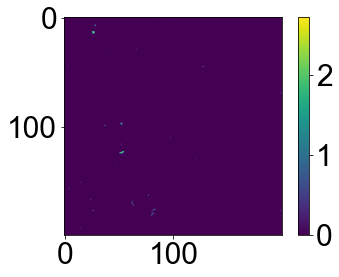

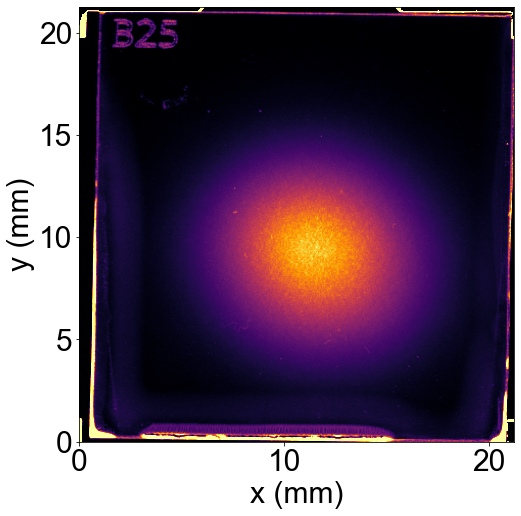

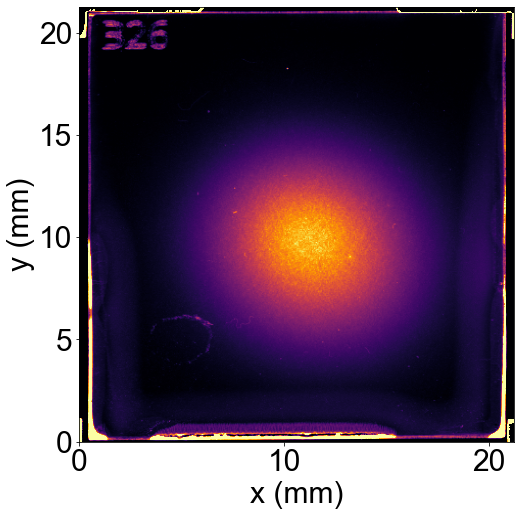

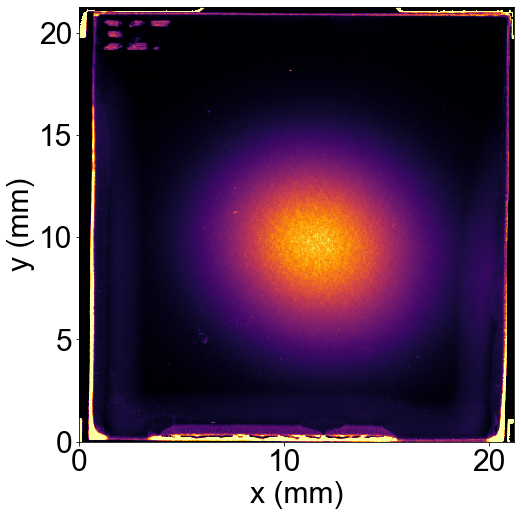

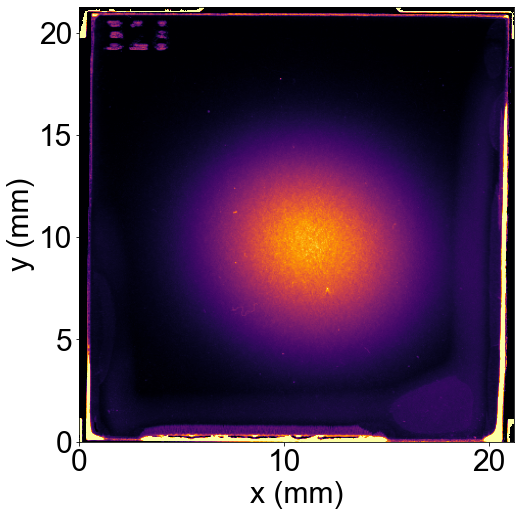

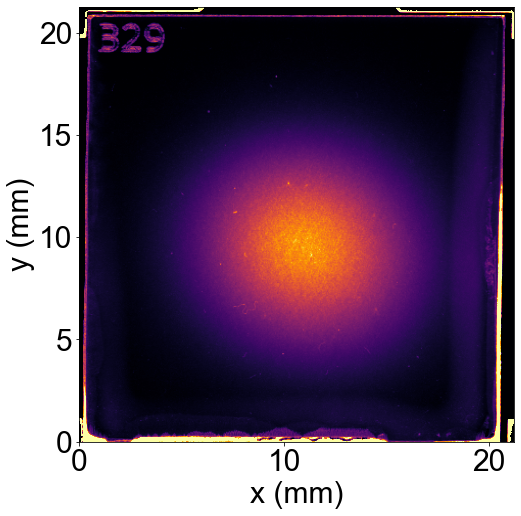

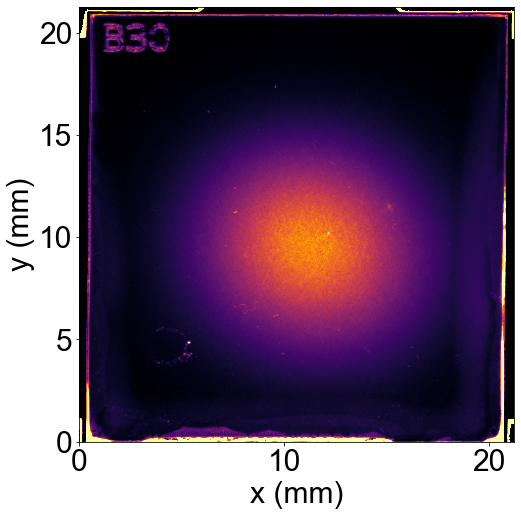

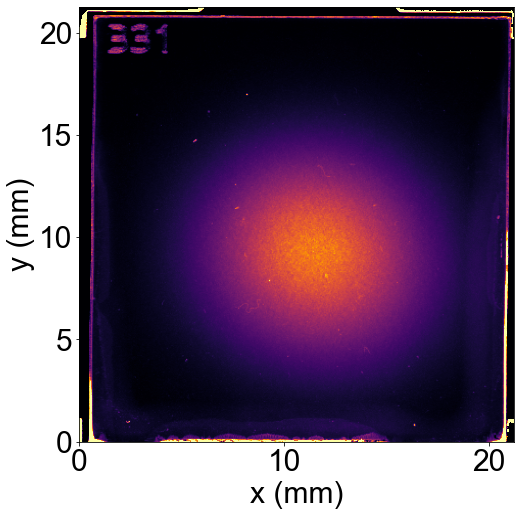

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import scipy
import pandas as pd
from PIL import Image
import os
from skimage.feature import peak_local_max
import imageio



maxdose=8e8/4
energy=140


%matplotlib inline
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 30}


matplotlib.rc('font', **font)


#Get and calibrate films################################################################3
film_r=[]
film_g=[]
film_b=[]
directory = 'D:/Desktop/thesis/GRID at CERN/GRID/08_11_22/run2/'
for i in np.arange(24,30+1):
    input_image = np.array(Image.open(directory+'Film_0'+str(i)+'.tif').convert("RGB")).T
    film_r.append(input_image[0].T)
    film_g.append(input_image[1].T)
    film_b.append(input_image[2].T)
#apply calibration corrections
#Joe's values 
a_r = 1.08979454e-02;b_r = 4.31528862e-04;c_r = 4.52890034e+00
a_g = 1.30365440e-02;b_g = 2.18523305e-04;c_g = 5.47818342e+00
a_b = 1.83975349e-02;b_b = 4.03633386e-04;c_b = 1.10176866e+01


film_r=np.array(film_r)/65535
film_r=np.array([(a_r - c_r * i) / (i - b_r) for i in film_r])
film_g=np.array(film_g)/65535
film_g=np.array([(a_g - c_g * i) / (i - b_g) for i in film_g])
film_b=np.array(film_b)/65535
film_b=np.array([(a_b - c_b * i) / (i - b_b) for i in film_b])
###########################################################################################

#Background films
background=np.array(Image.open(directory+'film_bkg01.tif').convert("RGB")).T
input_image = background
bkg_r=np.array([input_image[0].T]).squeeze()
bkg_g=np.array([input_image[1].T]).squeeze()
bkg_b=np.array([input_image[2].T]).squeeze()

bkg_r=np.array(bkg_r)/65535
bkg_r=np.array([(a_r - c_r * i) / (i - b_r) for i in bkg_r]).clip(min=0)
bkg_g=np.array(bkg_g)/65535
bkg_g=np.array([(a_g - c_g * i) / (i - b_g) for i in bkg_g]).clip(min=0)
bkg_b=np.array(bkg_b)/65535
bkg_b=np.array([(a_b - c_b * i) / (i - b_b) for i in bkg_b]).clip(min=0)

bkg_dose_r=np.mean(bkg_r[100:300,100:300])
bkg_dose_g=np.mean(bkg_g[100:300,100:300])
bkg_dose_b=np.mean(bkg_b[100:300,100:300])

figure(1)
plt.imshow(bkg_g[100:300,100:300])
plt.colorbar()
###############################################################################

#Open beam analysis
OB=np.array(film_g-bkg_dose_g)/(10.5e-9/0.15)
OBxfilm=np.array([13,18,23,33,43,53,63]) ########### film locations

OBpeaks=[]
OBpeaks_err=[]
profiles1d=[]
for k in range(len(OB)):
    #find indices of maxima
    xy=[]
    xy = peak_local_max(scipy.ndimage.gaussian_filter(OB[k,100:300,100:300],sigma=10),threshold_abs=2,num_peaks=1)
    xy=[xy[0,1]+100,xy[0,0]+100]
    if k==0:
        OBfirstpeak=xy[1]
    #plot 2d profiles
    figure(k+80,figsize=(8,8))
    profile=OB[k,xy[1]-125:xy[1]+126,xy[0]-125:xy[0]+126]
    plt.imshow(OB[k],vmin=0,vmax=maxdose,cmap='inferno',extent=(0,len(profile)/300*25.4,0,len(profile)/300*25.4))
    #plt.colorbar(fraction=0.046, pad=0.04,label='Dose rate (Gy/s)')
    #plt.scatter(125/300*25.4,125/300*25.4,s=20,c='red')
    #plt.text(16,20,str(OBxfilm[k])+'mm',c='white')
    #plt.text(8.7,20,str(energy)+'MeV',c='white')
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.savefig('D:Desktop/thesis/film_analysis/OB'+str(k)+'_'+str(energy)+'.png')
    profiles1d.append(np.mean([OB[k,i] for i in np.arange(xy[1]-10,xy[1]+11)],axis=0))
    
    #ROI for PDDs
    OBpeaks.append(np.mean([OB[k,i,j] for i in np.arange(xy[1]-10,xy[1]+10) for j in np.arange(xy[0]-10,xy[0]+10)]))
    OBpeaks_err.append(np.std([OB[k,i,j] for i in np.arange(xy[1]-10,xy[1]+10) for j in np.arange(xy[0]-10,xy[0]+10)])/np.sqrt(len([OB[k,i,j] for i in np.arange(xy[1]-10,xy[1]+10) for j in np.arange(xy[0]-10,xy[0]+10)])))
OBpeaks=np.array(OBpeaks)
OBpeaks_err=np.array(OBpeaks_err)

#animation
frames=[]
for k in range(len(OB)):
    frames.append(imageio.imread('D:Desktop/thesis/film_analysis/OB'+str(k)+'_'+str(energy)+'.png'))
imageio.mimsave('D:Desktop/thesis/film_analysis/OB'+str(energy)+'.gif', frames,'GIF-FI',quantizer='nq',duration=0.5)

savethis=np.array([OB,OBxfilm,OBpeaks,OBpeaks_err,np.arange(0,len(OB[0,OBfirstpeak]))/300*25.4,profiles1d],dtype=object)
np.save('D:Desktop/thesis/140MeVOB.npy',savethis)
print('background dose='+str(bkg_dose_g))

In [3]:
maxdose=18
maxdose=1e8
energy=140
%matplotlib qt
#Get and calibrate films#########################################
film_r=[]
film_g=[]
film_b=[]
directory = 'D:/Desktop/thesis/GRID at CERN/GRID/08_11_22/run2/'

for i in np.arange(2,12+1):
    input_image = np.array(Image.open(directory+'Film_00'+str(i)+'.tif').convert("RGB")).T
    film_r.append(input_image[0].T)
    film_g.append(input_image[1].T)
    film_b.append(input_image[2].T)
#apply calibration corrections
#Joe's values 
a_r = 1.08979454e-02;b_r = 4.31528862e-04;c_r = 4.52890034e+00
a_g = 1.30365440e-02;b_g = 2.18523305e-04;c_g = 5.47818342e+00
a_b = 1.83975349e-02;b_b = 4.03633386e-04;c_b = 1.10176866e+01


film_r=np.array(film_r)/65535
film_r=np.array([(a_r - c_r * i) / (i - b_r) for i in film_r])
film_g=np.array(film_g)/65535
film_g=np.array([(a_g - c_g * i) / (i - b_g) for i in film_g])
film_b=np.array(film_b)/65535
film_b=np.array([(a_b - c_b * i) / (i - b_b) for i in film_b])
###########################################################################################

#Background films
background=np.array(Image.open(directory+'film_bkg01.tif').convert("RGB")).T
input_image = background
bkg_r=np.array([input_image[0].T]).squeeze()
bkg_g=np.array([input_image[1].T]).squeeze()
bkg_b=np.array([input_image[2].T]).squeeze()

bkg_r=np.array(bkg_r)/65535
bkg_r=np.array([(a_r - c_r * i) / (i - b_r) for i in bkg_r]).clip(min=0)
bkg_g=np.array(bkg_g)/65535
bkg_g=np.array([(a_g - c_g * i) / (i - b_g) for i in bkg_g]).clip(min=0)
bkg_b=np.array(bkg_b)/65535
bkg_b=np.array([(a_b - c_b * i) / (i - b_b) for i in bkg_b]).clip(min=0)

bkg_dose_r=np.mean(bkg_r[100:300,100:300])
bkg_dose_g=np.mean(bkg_g[100:300,100:300])
bkg_dose_b=np.mean(bkg_b[100:300,100:300])

figure(1)
plt.imshow(bkg_g[100:300,100:300])
plt.colorbar()
###############################################################################
print(np.shape(film_g))
#GRID 200 MeV
GRID=np.array(film_g-bkg_dose_g)/(19.2e-9/0.15)
xfilm=np.arange(13,63+1,5) ######### film locations

peaks=[]
peaks_std=[]
valleys=[]
valleys_std=[]
for k in range(len(GRID)):

    #Find peak indices
    xy = peak_local_max(scipy.ndimage.gaussian_filter(GRID[k,100:300,100:300],sigma=3),threshold_abs=1,num_peaks=1)
    xy=[xy[0,1]+100,xy[0,0]+100]
    if k==0:
        firstpeak=xy[1]
    if k==1:
        xy=[140+100,151+100]
    #plot 2d profiles
    figure(k+30,figsize=(8,8))
    profile=GRID[k,xy[1]-125:xy[1]+126,xy[0]-125:xy[0]+126]
    plt.imshow(GRID[k],vmin=0,vmax=maxdose,cmap='inferno')#,extent=(0,len(profile)/300*25.4,0,len(profile)/300*25.4))
    #plt.colorbar(shrink=0.6,label='Dose (Gy)')
    #plt.scatter(125/300*25.4,125/300*25.4,s=20,c='red')
   # plt.text(16,19.5,str(xfilm[k])+'mm',c='white')
    #plt.text(8.7,19.5,str(energy)+'MeV',c='white')
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.savefig('D:Desktop/thesis/film_analysis/GRID'+str(k)+'_'+str(energy)+'.png')
    #for i in np.arange(0,len(np.array([(i,j) for i in np.arange(xy[1]-7,xy[1]+7) for j in np.arange(xy[0]-11,xy[0]-8)]).T[0])):
        #plt.scatter(np.array([(i,j) for i in np.arange(xy[1]-7,xy[1]+7) for j in np.arange(xy[0]-11,xy[0]-8)]).T[1],np.array([(i,j) for i in np.arange(xy[1]-7,xy[1]+7) for j in np.arange(xy[0]-11,xy[0]-8)]).T[0],alpha=0.4)
    #for i in np.arange(0,len(np.array([(i,j) for i in np.arange(xy[1]-11,xy[1]-8) for j in np.arange(xy[0]-7,xy[0]+7)]).T[0])):
        #plt.scatter(np.array([(i,j) for i in np.arange(xy[1]-11,xy[1]-8) for j in np.arange(xy[0]-7,xy[0]+7)]).T[1],np.array([(i,j) for i in np.arange(xy[1]-11,xy[1]-8) for j in np.arange(xy[0]-7,xy[0]+7)]).T[0],alpha=0.4)
    #ROIs for peaks and valleys + error
    peaks.append(np.mean([[GRID[k,i,j] for i in np.arange(xy[1]-1,xy[1]+2) for j in np.arange(xy[0]-1,xy[0]+2)]]))
    peaks_std.append(np.std([GRID[k,i,j] for i in np.arange(xy[1]-1,xy[1]+2) for j in np.arange(xy[0]-1,xy[0]+2)])/np.sqrt(len([GRID[k,i,j] for i in np.arange(xy[1]-1,xy[1]+2) for j in np.arange(xy[0]-1,xy[0]+2)])))
    valleysx=np.array([GRID[k,i,j] for i in np.arange(xy[1]-11,xy[1]-8) for j in np.arange(xy[0]-7,xy[0]+7)]).flatten()
    valleysy=np.array([GRID[k,i,j] for i in np.arange(xy[1]-7,xy[1]+7) for j in np.arange(xy[0]-11,xy[0]-8)]).flatten()
    valleys.append(np.mean(np.array([valleysx,valleysy]).flatten()))
    valleys_std.append(np.std(np.array([valleysx,valleysy]).flatten())/np.sqrt(len(np.array([valleysx,valleysy]).flatten())))
peaks=np.array(peaks)
peaks_std=np.array(peaks_std)

#pvdr
pvdr=peaks/np.array(valleys)
pvdr_std=np.sqrt((np.array(peaks_std)/np.array(peaks))**2+(np.array(valleys_std)/np.array(valleys))**2)*pvdr

#PDD
figure(13+30,figsize=(7,7))
plt.plot(xfilm,peaks,marker='o',label='GRID',lw=3,markersize=10)
plt.fill_between(xfilm,peaks-peaks_std,peaks+peaks_std,alpha=0.4)
plt.plot(OBxfilm,OBpeaks,marker='o',label='Open beam',lw=3,markersize=10)
plt.fill_between(OBxfilm,OBpeaks-OBpeaks_err,OBpeaks+OBpeaks_err,alpha=0.4)
plt.grid(c='lightgray')  
plt.xlabel('Depth in water (mm)')
plt.ylabel('Dose (Gy)')
plt.xlim(xfilm[0]-1,xfilm[-1]+1)
plt.ylim(0,maxdose)
plt.title('GRID '+str(energy)+' MeV Depth-Dose')
plt.legend()


#PVDR vs depth
figure(13+31,figsize=(7,7))
plt.plot(xfilm,pvdr,marker='o',label='Real data',lw=3,markersize=10)
plt.fill_between(xfilm,pvdr-pvdr_std/peaks*pvdr,pvdr+pvdr_std/peaks,alpha=0.4)
plt.grid(c='lightgray')  
plt.xlabel('Depth in water (mm)')
plt.ylabel('PVDR')
plt.xlim(xfilm[0]-1,xfilm[-1]+1)
plt.ylim(0,4)
plt.title('GRID '+str(energy)+' MeV PVDR(d)')


#1d profile
peakindgrid=np.argmax(np.mean([GRID[0,i] for i in np.arange(firstpeak-10,firstpeak+11)],axis=0)[20:-20])
peakindOB=np.argmax(np.mean([OB[0,i] for i in np.arange(OBfirstpeak-10,OBfirstpeak+11)],axis=0)[20:-20])
figure(14+32,figsize=(7,7))
plt.plot((np.arange(0,len(GRID[0,firstpeak]))-peakindgrid+peakindOB)/300*25.4,GRID[0,firstpeak],lw=3,markersize=10,label='GRID')
plt.plot(np.arange(0,len(OB[0,OBfirstpeak]))/300*25.4,np.mean([OB[0,i] for i in np.arange(OBfirstpeak-10,OBfirstpeak+11)],axis=0),lw=3,markersize=10,label='Open beam')
plt.grid(c='lightgray')
plt.xlabel('x (mm)')
plt.ylabel('Dose (Gy)')
plt.xlim(np.arange(0,len(OB[0,OBfirstpeak]))[np.argmax(np.mean([OB[0,i] for i in np.arange(OBfirstpeak-10,OBfirstpeak+11)],axis=0)[20:-20])]/300*25.4-10,np.arange(0,len(OB[0,OBfirstpeak]))[np.argmax(np.mean([OB[0,i] for i in np.arange(OBfirstpeak-10,OBfirstpeak+11)],axis=0)[20:-20])]/300*25.4+10)
plt.ylim(0,maxdose)
plt.title('1D central profile GRID '+str(energy)+' MeV')
plt.legend()

#animation
frames=[]
for k in range(len(GRID)):
    frames.append(imageio.imread('D:Desktop/thesis/film_analysis/GRID'+str(k)+'_'+str(energy)+'.png'))
imageio.mimsave('D:Desktop/thesis/film_analysis/GRID'+str(energy)+'.gif', frames,'GIF-FI',quantizer='nq',duration=0.5)

print('background dose='+str(bkg_dose_g))

print(np.interp(1.1,np.flip(pvdr),np.flip(xfilm)))
print(pvdr,pvdr_std/peaks*pvdr)
print(peaks)
x1=np.array(peaks)
x2=np.array(peaks_std)
x3=np.array((np.arange(0,len(GRID[0,firstpeak]))-peakindgrid+peakindOB)/300*25.4)
x4=np.array(GRID[0,firstpeak])
x5=np.array(pvdr)
x6=np.array(pvdr_std)
savethis=np.array([GRID,x1,x2,x3,x4,x5,x6,valleys,valleys_std],dtype=object)
np.save('D:Desktop/thesis/140MeV.npy',savethis)
print(np.shape(GRID[0]))

(11, 476, 426)
background dose=0.0011502006548094088
38.968341288203355
[2.2865513  1.8472184  1.53478344 1.28508449 1.16576274 1.11405228
 1.04149376 1.02546614 1.04201704 1.04151756 1.02075746] [1.30117971e-09 8.40034768e-10 4.22501452e-10 2.65933041e-10
 5.72886529e-10 7.77690169e-10 4.35554367e-10 3.12054723e-10
 4.01660036e-10 1.09568523e-09 4.97178822e-10]
[85143783.42541559 64010080.93871471 51903673.73334748 42827254.40267598
 37801156.95839811 33968021.34721252 30919900.54984889 28038687.79488115
 27675851.75146843 26035532.36631625 24213634.74249727]
(476, 426)


In [4]:
film_r=[]
film_g=[]
film_b=[]
# assign directory
directory = 'D:/Desktop/thesis/GRID at CERN/GRID/10_11_22/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        input_image = np.array(Image.open(directory+filename).convert("RGB")).T
        film_r.append(input_image[0].T)
        film_g.append(input_image[1].T)
        film_b.append(input_image[2].T)
#apply calibration corrections
#Joe's values 
a_r = 1.08979454e-02;b_r = 4.31528862e-04;c_r = 4.52890034e+00
a_g = 1.30365440e-02;b_g = 2.18523305e-04;c_g = 5.47818342e+00
a_b = 1.83975349e-02;b_b = 4.03633386e-04;c_b = 1.10176866e+01


film_r=np.array(film_r)/65535
film_r=np.array([(a_r - c_r * i) / (i - b_r) for i in film_r])
film_g=np.array(film_g)/65535
film_g=np.array([(a_g - c_g * i) / (i - b_g) for i in film_g])
film_b=np.array(film_b)/65535
film_b=np.array([(a_b - c_b * i) / (i - b_b) for i in film_b])


#Open beam 200 MeV
OB200=np.flip(np.array([film_r[i] for i in np.arange(0,9)]),axis=0)

peaks=[]
peak_std=[]
for k in range(len(OB200)):
    maxim=[]
    xy = peak_local_max(scipy.ndimage.gaussian_filter(OB200[k,100:300,100:300],sigma=5),threshold_abs=2,num_peaks=1)
    xy=[xy[0][1]+100,xy[0][0]+100]
    
    
#     figure(k,figsize=(8,8))
#     plt.imshow(OB200[k],vmin=0,vmax=20)
#     plt.colorbar(shrink=0.6)
#     plt.scatter(xy[0],xy[1],s=20,c='red')
    print(xy)
    peaks.append(np.mean(OB200[k][xy[1]-10:xy[1]+11,xy[0]-10:xy[0]+11]))
    peak_std.append(np.std(OB200[k][xy[1]-10:xy[1]+11,xy[0]-10:xy[0]+11])/np.sqrt(len(OB200[k][xy[1]-10:xy[1]+11,xy[1]-10:xy[1]+11])))
peaks=np.array(peaks)
peak_std=np.array(peak_std)

scaling_factor=np.mean([1.06591963, 1.0616744,  1.06172921, 1.05989523, 1.06517271, 1.05766583,1.05946036, 1.05321091, 1.05442651])
print(scaling_factor)

IndexError: index 0 is out of bounds for axis 0 with size 0